<a href="https://colab.research.google.com/github/AguaClara/Textbook/blob/flocsandforces/Flocs_Fractals_and_Forces/Colab/FFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install aguaclara
!pip install molmass

     |████████████████████████████████| 92kB 3.6MB/s 
     |████████████████████████████████| 215kB 6.2MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.6-cp36-none-any.whl size=101373 sha256=0cef7a2faa6fee6835430220adce98f3d941e14087a97e25bdb66a89e2c31a57
  Stored in directory: /root/.cache/pip/wheels/a6/9a/d5/cab5970c57dfc0099454b36812306b976c217408b39e7a379a
Successfully built aguaclara
     |████████████████████████████████| 71kB 3.3MB/s 


In [36]:
from aguaclara.core.units import unit_registry as u
import aguaclara as ac
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker

font = 'x-large'
params = {'legend.fontsize': font,
         'figure.figsize': (8,6),
         'axes.labelsize': font,
         'axes.titlesize':font,
         'xtick.labelsize':font,
         'ytick.labelsize':font,
         'axes.formatter.useoffset':False}
plt.rcParams.update(params)

In [73]:


def v_terminal(temp, particle_RHO , particle_D):
  """ calculate the terminal velocity both in the laminar and transition
  range. Uses iteration to find solution in the transition range."""
  Nu = ac.viscosity_kinematic_water(temp)
  water_RHO = ac.density_water(temp)
  v_terminal_laminar = (u.gravity * particle_D**2 * (particle_RHO - water_RHO)) / ( 18 * Nu * water_RHO)
  Re = (v_terminal_laminar * particle_D / Nu ).to(u.dimensionless)
  if Re < 1: 
    return v_terminal_laminar.to(u.mm/u.s)
  else:
    error = 1 
    Re_prev = Re
    i = 0
    while error >= 0.01 and i<50: 
      coefficient_drag = (24/Re_prev)*(1 + 0.150*Re_prev**0.681) + (0.407 / (1 + (8710/Re_prev)))
      terminal_V = (4 * u.gravity * particle_D * (particle_RHO - water_RHO) / (3 * coefficient_drag * water_RHO) )**0.5
      Re_new = (terminal_V * particle_D / Nu ).to(u.dimensionless)
      error = np.abs((Re_new - Re_prev )/(Re_new + Re_prev)) 
      Re_prev = Re_new
    return terminal_V.to(u.mm/u.s) 

def d_hydraulic(Width, Length):
  """ calculates the hydraulic diameter from the hydraulic radius
  The hydraulic diameter is 4* the radius... """
  return 4 * ac.radius_hydraulic_rect(Width, Length, False)

def v_terminal_wall_effects(temp, particle_RHO , particle_D, hydraulic_D):
  return (v_terminal(temp, particle_RHO , particle_D) / (10**(particle_D/hydraulic_D))).to(u.mm/u.s)

def fluidization_index(temp, particle_RHO , particle_D, hydraulic_D):
  Re_corrected = ((v_terminal_wall_effects(temp, particle_RHO , particle_D, hydraulic_D)*particle_D )/ac.viscosity_kinematic_water(temp)).to(u.dimensionless)
  return (0.65*(2+ (0.5 * Re_corrected**0.65)))/(1 + (0.5 * Re_corrected**0.65))

def porosity_fluidized_bed(temp, particle_RHO , particle_D, hydraulic_D,static_bed_PHI, v_z):
  z = fluidization_index(temp, particle_RHO , particle_D, hydraulic_D)
  terminal_V_wall = v_terminal_wall_effects(temp, particle_RHO , particle_D, hydraulic_D)
  return ( ((v_z/terminal_V_wall)**(1/z) * (1-static_bed_PHI)) + static_bed_PHI).to(u.dimensionless)

@ac.list_handler()
def vel_term_floc(coreD, coreRHO, fractalPI, flocD, Temp):
  """Calculate floc terminal velocity based on the properties
  of the core particle"""
  waterRHO = ac.density_water(Temp)
  waterNU = ac.viscosity_kinematic_water(Temp)
  return (((u.gravity * coreD**2)
            / (18 *  waterNU)
            )
          * ((coreRHO - waterRHO
              )
              / waterRHO
              )
          * (flocD / coreD) ** (fractalPI - 1)
          ).to(u.mm/u.s)

@ac.list_handler()
def flocDofG(bondF,Gmax,Temp):
  return (np.sqrt(4*bondF/(3 * np.pi * ac.viscosity_dynamic_water(Temp) * Gmax))).to(u.um)

@ac.list_handler()
def GmaxofFlocD(bondF,flocD,Temp):
  return (4*bondF/(3 * np.pi * ac.viscosity_dynamic_water(Temp) * flocD**2)).to(u.Hz)

@ac.list_handler()
def GmaxofFlocD(bondF,flocD,Temp):
  return (4*bondF/(3 * np.pi * ac.viscosity_dynamic_water(Temp) * flocD**2)).to(u.Hz)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Upflow velocity $\\left(\\frac{mm}{s}\\right)$')

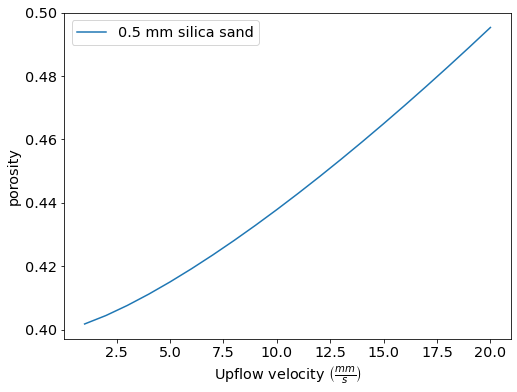

In [65]:
temp = 20 * u.degC
sand_D = 0.5 * u.mm
sand_RHO = 2650 * u.kg/u.m**3
filter_W = 1 * u.m
filter_L = 1 * u.m
hydraulic_D = d_hydraulic(filter_W,filter_L)

static_bed_PHI = 0.4
v_z = np.linspace(1,20,20) * 1 * u.mm/u.s
sand_PHI = porosity_fluidized_bed(temp, sand_RHO , sand_D, hydraulic_D,static_bed_PHI, v_z)
plt.plot(v_z,sand_PHI)
plt.legend(["0.5 mm silica sand"])
plt.ylabel(r"Porosity")
plt.xlabel(r"Upflow velocity $\left(\frac{mm}{s}\right)$")


#Terminal velocity of flocs

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False

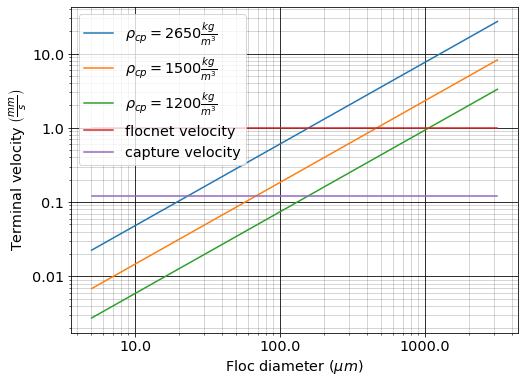

In [91]:
flocD = np.logspace(0.7,3.5,50) * 1*u.um 
Temp = 20*u.degC
coreRHO = 2650 * u.kg/u.m**3
coreD = 5 * u.um
fractalPI = 2.1
plt.loglog(flocD,vel_term_floc(coreD, 2650 * u.kg/u.m**3, fractalPI, flocD, Temp))
plt.loglog(flocD,vel_term_floc(coreD, 1500 * u.kg/u.m**3, fractalPI, flocD, Temp))
plt.loglog(flocD,vel_term_floc(coreD, 1200 * u.kg/u.m**3, fractalPI, flocD, Temp))
plt.loglog(flocD,np.full_like(flocD,1*u.mm/u.s))
plt.loglog(flocD,np.full_like(flocD,0.12*u.mm/u.s))

# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='black', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
plt.legend([r"$\rho_{cp} = 2650\frac{kg}{m^3}$",r"$\rho_{cp} = 1500\frac{kg}{m^3}$",r"$\rho_{cp} = 1200\frac{kg}{m^3}$", "flocnet velocity", "capture velocity"])
plt.ylabel(r"Terminal velocity $\left(\frac{mm}{s}\right)$")
plt.xlabel(r"Floc diameter $(\mu m)$")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


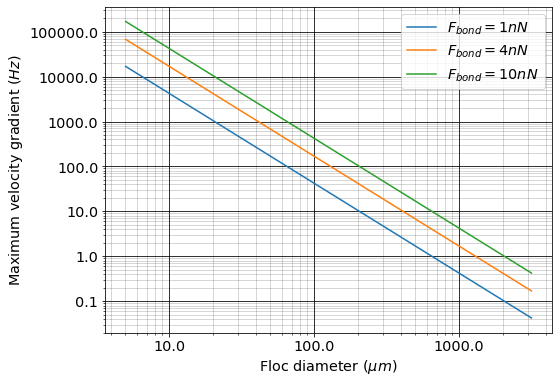

In [92]:
#max velocity gradient as function of floc diameter
bondF = 4 * u.nN
plt.loglog(flocD,GmaxofFlocD(1 * u.nN,flocD,Temp))
plt.loglog(flocD,GmaxofFlocD(4 * u.nN,flocD,Temp))
plt.loglog(flocD,GmaxofFlocD(10 * u.nN,flocD,Temp))
# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='black', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
plt.legend([r"$F_{bond} = 1nN$",r"$F_{bond} = 4nN$",r"$F_{bond} = 10nN$"])
plt.ylabel(r"Maximum velocity gradient $\left(Hz\right)$")
plt.xlabel(r"Floc diameter $(\mu m)$")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))

[0.01 0.622 1.234 1.846 2.458 3.07 3.682 4.294 4.906 5.518 6.13 6.742 7.354 7.967 8.579 9.191 9.803 10.41 11.03 11.64 12.25 12.86 13.47 14.09 14.7 15.31 15.92 16.54 17.15 17.76 18.37 18.98 19.6 20.21 20.82 21.43 22.04 22.66 23.27 23.88 24.49 25.1 25.72 26.33 26.94 27.55 28.16 28.78 29.39 30] degree_Celsius


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


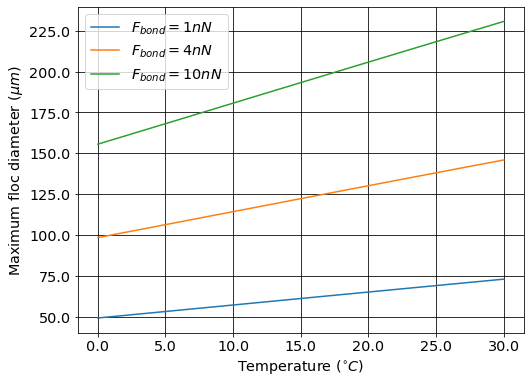

In [89]:
# floc size as a function of temperature
TempGraph = np.linspace(0.01,30,50) * u.degC
print(TempGraph)
Gmax = 100 * u.Hz
bondF = 4 * u.nN
plt.plot(TempGraph,flocDofG(1 * u.nN,Gmax,TempGraph))
plt.plot(TempGraph,flocDofG(4 * u.nN,Gmax,TempGraph))
plt.plot(TempGraph,flocDofG(10 * u.nN,Gmax,TempGraph))

# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='black', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
plt.legend([r"$F_{bond} = 1nN$",r"$F_{bond} = 4nN$",r"$F_{bond} = 10nN$"])
plt.xlabel(r"Temperature $(^{\circ}C)$")
plt.ylabel(r"Maximum floc diameter $\left(\mu m\right)$")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))

In [15]:



### calculating porosity ###
v_up= 1*u.mm/u.s
static_bed_pore_frac = 0.4 
porosity_fb = (((v_up/v_terminal_corrected)**(1/z) *(1-static_bed_pore_frac)) + static_bed_pore_frac).to(u.dimensionless)
print('The porosity of the floc blanket is ', porosity_fb)

### turning porosity to a density ### 
conc_clay_fb = ((D_0/D_max)**(3-D_fractal) * density_primary_floc *(1-porosity_fb)).to(u.g/u.l)
print('The floc blanket clay concentration is ',conc_clay_fb)

NameError: ignored

In [ ]:
temp = 20*u.degC
D_clay = 5*u.micrometer 
Clay_Density = 2650 * u.kg/u.m**3 
Nu = ac.viscosity_kinematic_water(temp)

diam_sand = 0.5*u.mm
porosity= 0.4 
head_loss_filter = 40*u.cm #### 
height_filter = 20*u.cm #### Need to get this info 

sep_dist_sand_pore = ((np.pi / 6*(1-porosity))**(1/3) )*diam_sand
velo_constriction_max = ((2*u.gravity*sep_dist_sand_pore*head_loss_filter) / height_filter)**(1/2)
Pi_bond_dis = 0.7

force_point_1 = (( (3*np.pi * Nu * velo_constriction_max * D_clay * ac.density_water(temp) ) + ( (Clay_Density - ac.density_water(temp) )*(u.gravity *np.pi * D_clay**3 / 6 ))  )* (1 /(2 *Pi_bond_dis) )).to(u.nanonewton)
print(force_point_1)



## Hypothesis about what determines floc size in the floc blanket 

The floc blanket is a complex system where we believe flocs are being formed and distroyed simultaneously. Modeling the forces exerted on an individual floc is a critical part of understanding what the size limit of a floc in the blanket might be. We hypothesize that if we can find the average size of a floc in the floc blanket then we can estimate the primary particle concentration of the blanket. Blanket concentration is a key indicator for overall sed tank performance, according to experimental data. 

In the floc blanket there are various types of flocs: 

* Fully grown flocs that can no longer grow further, ie "mature flocs" 
* Primary particles coming in from the diffusers 
* Spectrum of floc sizes between the previous two floc types that either come from the diffuser or result from the break up of larger flocs in the jet reverser or floc blanket 

The collision of two flocs with identical settling velocities in a floc blanket is unlikely given that the upward flow in the sed tank produces little to no velocity gradients. Collisions in this type of reactor depend highly on differencial sedimentation. Given this, we hypothesize that small flocs and primary particles with terminal velocities much less than the upflow velocity attach easily to the stagnation point of larger flocs which have terminal velocites close to or greater than the upflow velocity in the sed tank. As the larger floc accumulates more primary particles and other smaller flocs, its terminal velocity increases. There will come a point however, where the drag force experienced by one of the smaller flocs bonded to the surface of the large mature floc is larger than the force of the coagulant bond. This may be what is setting the ultimate size of flocs in the blanket. 

Given this, we want to find the floc size that if attached to the surface of the mature floc would be ripped apart from it. It is suspected that primary particles do not experience enough fluid shear to be removed. As that floc gets bigger, the more shear force is trying to yank the floc off the mature floc and the more gravitational force is pulling it down. There is critical floc size that experience the most force and we would like to find critical value. 



In [ ]:
D_0 = 5*u.micrometer
D_mature= 0.5*u.mm
D_fractal = 2.3
pi_bond_dist = 0.7
density_primary_floc = 2650 * u.kg/u.m**3 
temp = 15*u.degC
Diam_adj_floc = [] # in micrometer
F_bond = [] # in nanonewtons 

start = (D_0.to(u.micrometer)).magnitude
stop = (D_mature.to(u.micrometer)).magnitude

for D_adj in np.arange(start, stop): 
  D_adj_unit = D_adj*u.micrometer
  force_bond = ((1/12) * (1/pi_bond_dist) * np.pi * u.gravity * D_adj_unit * D_0**2 * (density_primary_floc - ac.density_water(temp)) * ( (D_mature / D_0)**(D_fractal-1) - (D_adj_unit/D_0)**(D_fractal-1)) ).to(u.nanonewton)
  Diam_adj_floc.append(D_adj_unit.magnitude)
  F_bond.append(force_bond.magnitude)

max_force = max(x for x in F_bond if x is not None) # Finds max force in the list 
index_max_force = F_bond.index(max_force) # find the index of the max force to then find the associated adj diameter
diam_adj_at_max_force = Diam_adj_floc[index_max_force]*u.micrometer
diam_ratio = (diam_adj_at_max_force/D_mature).to(u.dimensionless)
print(diam_ratio)

plt.figure(1,[10,8])
plt.plot(Diam_adj_floc,F_bond)
plt.xlabel('Diameter of adjacent floc (um)')
plt.ylabel('Force on bond (nN)')
plt.title('Force on bond between an adjacent floc and a mature floc of size '+ str(D_mature))




Based on the above analysis the ratio of $\frac{D_{adj}}{D_{mature}}$ that has the largest force is equal to 0.527. 

$$F_{drag_{adj}} + F_{drag_{mature}} + F_{Buoy_{adj}} + F_{Buoy_{mature}}- F_{grav_{adj}} - F_{grav_{mature}} =0 $$

$$F_{drag_{adj}} +  F_{Buoy_{adj}} - F_{grav_{adj}} - F_{Bond_{adj}}=0 $$

$$F_{drag_{mature}} +  F_{Buoy_{mature}} - F_{grav_{mature}} + F_{Bond_{mature}}=0 $$
- - - 

$$F_{drag_{adj}} +  F_{Buoy_{adj}} - F_{grav_{adj}} = F_{Bond_{adj}} $$

$$ -F_{drag_{mature}} -  F_{Buoy_{mature}} + F_{grav_{mature}} = F_{Bond_{mature}} $$

Instead of solving for the force on the bond directly we can make the force the independent variable and solve for the diameters of the mature and adjacent flocs. I dont see a way to solve for bond force as a function of the forces on mature floc and adjacent floc.  

Or finding the terminal velocity of the composite 

Or maybe we should treat them totally seperate? In this theory we are assuming that the adjacent floc as an appendage and not inbeded so it has its own force of drag , gravity, and buoyancy. 

## We will move away from this and instead look to find the terminal velocity of the composite floc made up of both the mature and adjacent. 

1. Find terminal velocity of the composite particle 

$$F_{drag_{adj}} + F_{drag_{mature}} + F_{Buoy_{adj}} + F_{Buoy_{mature}}- F_{grav_{adj}} - F_{grav_{mature}} =0 $$

$$ \frac{1}{2} C_D \rho_{H_2O} \frac{\pi D_{adj}^2}{4} v_{t}^2 + \frac{1}{2} C_D \rho_{H_2O} \frac{\pi D_{max}^2}{4} v_{t}^2 + \rho_{H_2O} \rlap{-}V_{adj} g + \rho_{H_2O} \rlap{-}V_{max} g  - \rho_{floc_{adj}} \rlap{-}V_{adj} g - \rho_{floc_{max}} \rlap{-}V_{max} g =0 $$

$$ \frac{1}{2} C_D \rho_{H_2O} \frac{\pi D_{adj}^2}{4} v_{t}^2 + \frac{1}{2} C_D \rho_{H_2O} \frac{\pi D_{max}^2}{4} v_{t}^2 + (\rho_{H_2O} - \rho_{adj}) g  \frac{\pi}{6}D_{adj}^3 + (\rho_{H_2O} - \rho_{max}) g  \frac{\pi}{6}D_{max}^3  =0 $$

If Re is below 40 then, 
$$C_D = \frac{24 \Phi}{Re} = \frac{24 \Phi \nu}{v_{t}D}$$

$$3 \pi \phi \nu \rho_{H_20} v_t (D_{adj} + D_{max}) +  g  \frac{\pi}{6} \big( (\rho_{H_2O} - \rho_{adj}) D_{adj}^3 + (\rho_{H_2O} - \rho_{max})D_{max}^3 \big) =0 $$

The following is the current equation for describing the density of a floc as a function of its size: 
$$\rho_{floc} = (\rho_{floc_0} -\rho_{H_2O}) ( \frac{D_0}{D_{floc}})^{3-D_{fractal}} + \rho_{H_2O}$$

If we plug this into the equation we get the following: 

$$3 \pi \phi \nu \rho_{H_20} v_t (D_{adj} + D_{max}) +  g  \frac{\pi}{6}  (\rho_{H_2O} - \rho_{floc_0}) \bigg[D_{adj}^3\bigg(\frac{D_0}{D_{adj}} \bigg)^{3-D_{frac}} + D_{max}^3\bigg(\frac{D_0}{D_{max}} \bigg)^{3-D_{frac}} \bigg] =0 $$

simplifying this expression we get: 

$$3 \pi \phi \nu \rho_{H_20} v_t (D_{adj} + D_{max}) +  g  \frac{\pi}{6}  (\rho_{H_2O} - \rho_{floc_0}) D_{0}^2 \bigg[D_{adj}\bigg(\frac{D_{adj}}{D_0} \bigg)^{D_{frac}-1} + D_{max}\bigg(\frac{D_{max}}{D_0} \bigg)^{D_{frac}-1} \bigg]=0 $$

Now we can solve for the terminal velocity $v_t$ of the composite floc: 

$$v_t = \frac {g (\rho_{floc_0}- \rho_{H_2O} ) D_0^2} {18  \phi \nu \rho_{H_20} (D_{adj} + D_{max})} \bigg[D_{adj}\bigg(\frac{D_{adj}}{D_0} \bigg)^{D_{frac}-1} + D_{max}\bigg(\frac{D_{max}}{D_0} \bigg)^{D_{frac}-1} \bigg]$$

The next step is to do a force balance on the adjacent floc to determine the force of the bond between the two flocs. 

## bond force calculations
The forces in the y direction experienced by the adjacent floc are: 
$$F_{y_{bond}} = F_{drag_{adj}} + F_{Buoyancy_{adj}} - F_{gravity_{adj}}$$


$$ F_{y_{bond}}= 3 \pi \phi \nu \rho_{H_20} v_t D_{adj}  + (\rho_{H_2O} - \rho_{adj}) g  \frac{\pi}{6}D_{adj}^3 $$

Substituting for $\rho_{adj}$ we get: 

$$ F_{y_{bond}}= 3 \pi \phi \nu \rho_{H_20} v_t D_{adj}  -  g  \frac{\pi}{6}(\rho_{floc_0}- \rho_{H_2O} ) D_0^2 D_{adj} \bigg(\frac{D_{adj}}{D_0} \bigg)^{D_{frac}-1}$$

Substituting for $v_t$ we get the following:

$$ F_{y_{bond}}= \frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O} ) D_0^2 D_{adj} \frac{D_{adj}\bigg(\frac{D_{adj}}{D_0} \bigg)^{D_{frac}-1} + D_{max}\bigg(\frac{D_{max}}{D_0} \bigg)^{D_{frac}-1} }{(D_{adj} + D_{max})} -  g  \frac{\pi}{6}(\rho_{floc_0}- \rho_{H_2O} ) D_0^2 D_{adj} \bigg(\frac{D_{adj}}{D_0} \bigg)^{D_{frac}-1}$$

Simplifying: 

$$ F_{y_{bond}}= \frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O} ) D_0^2 D_{adj} \bigg[ \frac{D_{adj}\bigg(\frac{D_{adj}} {D_0} \bigg)^{D_{frac}-1} + D_{max}\bigg(\frac{D_{max}}{D_0} \bigg)^{D_{frac}-1} }{(D_{adj} + D_{max})} -  \bigg(\frac{D_{adj}}{D_0} \bigg)^{D_{frac}-1} \bigg]$$

If we multiply the last term by $\frac{(D_{adj} + D_{max})}{(D_{adj} + D_{max})}$ we can simplify the expression to the following: 

$$ F_{y_{bond}}= \frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O} ) \frac{D_0^2 D_{adj} D_{max}}{(D_{adj} + D_{max})} \bigg[ \bigg(\frac{D_{max}}{D_0} \bigg)^{D_{frac}-1} -\bigg(\frac{D_{adj}}{D_0} \bigg)^{D_{frac}-1} \bigg]$$

This is now the final force experience by a bond in the y direction. 


Last thing left to do is to relate that force in the y direction to a tension force on a bond. This was done in the previous section and that result will be used here. 

$$F_{bond} = \frac {F_{y_{bond}}} {cos(\theta)} $$
$$cos(\theta) = \frac{L_{bond}}{D_{clay}} = \Pi_{bond \space distance} $$

$$F_1 = \frac {F_{1y}} {cos(\theta)} = \frac {F_{1y}}{\Pi_{bond \space distance} } $$

$$ F_{bond} = \frac{1}{2 \Pi_{bond \space distance}}\frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O} ) \frac{D_0^2 D_{adj} D_{max}}{(D_{adj} + D_{max})} \bigg[ \bigg(\frac{D_{max}}{D_0} \bigg)^{D_{frac}-1} -\bigg(\frac{D_{adj}}{D_0} \bigg)^{D_{frac}-1} \bigg]$$





In [ ]:
D_0 = 5*u.micrometer
D_mature= 0.5*u.mm
D_fractal = 2.3
pi_bond_dist = 0.7
density_primary_floc = 2650 * u.kg/u.m**3 
temp = 15*u.degC
Diam_adj_floc = [] # in micrometer
F_bond = [] # in nanonewtons 

start = (D_0.to(u.micrometer)).magnitude
stop = (D_mature.to(u.micrometer)).magnitude

for D_adj in np.arange(start,stop): 
  D_adj_unit = D_adj*u.micrometer
  force_bond = ((1/12) * (1/pi_bond_dist) * np.pi * u.gravity * ((D_adj_unit * D_0**2 * D_mature)/(D_adj_unit + D_mature)) *(density_primary_floc - ac.density_water(temp)) * ( (D_mature / D_0)**(D_fractal-1) - (D_adj_unit/D_0)**(D_fractal-1)) ).to(u.nanonewton)
  Diam_adj_floc.append(D_adj_unit.magnitude)
  F_bond.append(force_bond.magnitude)

max_force = max(x for x in F_bond if x is not None) # Finds max force in the list 
index_max_force = F_bond.index(max_force) # find the index of the max force to then find the associated adj diameter
diam_adj_at_max_force = Diam_adj_floc[index_max_force]*u.micrometer
diam_ratio = (diam_adj_at_max_force/D_mature).to(u.dimensionless)
print(diam_ratio)

plt.figure(1,[10,8])
plt.plot(Diam_adj_floc,F_bond)
plt.xlabel('Diameter of adjacent floc (um)')
plt.ylabel('Force on bond (nN)')
plt.title('Force on bond between an adjacent floc and a mature floc of size '+ str(D_mature))

Solving for $D_{max}$

from the above graph we know that max force occurs at the $\frac{D_{adj}}{D_{max}} = 0.44$. 
$$\Pi_{max \space force} =\frac{D_{adj}}{D_{max}} =0.44$$

This will help us solve for $D_{max}$ as a function of $F_{bond}$. 
Starting with the function of $F_{bond}$: 

$$ F_{bond} = \frac{1}{2 \Pi_{bond \space distance}}\frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O} ) \frac{D_0^2 D_{adj} D_{max}}{(D_{adj} + D_{max})} \bigg[ \bigg(\frac{D_{max}}{D_0} \bigg)^{D_{frac}-1} -\bigg(\frac{D_{adj}}{D_0} \bigg)^{D_{frac}-1} \bigg]$$

Substituting for $D_{adj}$: 

$$ F_{bond} = \frac{1}{2 \Pi_{bond \space distance}}\frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O} ) \frac{D_0^2 \Pi_{max \space force} D_{max}^2}{(\Pi_{max \space force}D_{max} + D_{max})} \bigg[ \bigg(\frac{D_{max}}{D_0} \bigg)^{D_{frac}-1} -\bigg(\frac{\Pi_{max \space force}D_{max}}{D_0} \bigg)^{D_{frac}-1} \bigg]$$

factor out and simplify: 

$$ F_{bond} =\frac{1}{2 \Pi_{bond \space distance}}\frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O} ) \frac{D_0^2 \Pi_{max \space force} D_{max}}{(\Pi_{max \space force} + 1)} \bigg(\frac{D_{max}}{D_0} \bigg)^{D_{frac}-1} \bigg(1- \Pi_{max \space force}^{D_{frac}-1} \bigg) $$

decomposing the $ \bigg(\frac{D_{max}}{D_0} \bigg)^{D_{frac}-1}$ and simplifying: 

$$ F_{bond} = \frac{1}{2 \Pi_{bond \space distance}}\frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O} ) \frac{\Pi_{max \space force}}{(\Pi_{max \space force} + 1)} D_{max}^{D_{frac}}D_0^{3-D_{frac}} \bigg(1- \Pi_{max \space force}^{D_{frac}-1} \bigg) $$

Solving for $D_{max}$: 

$$ D_{max}^{D_{frac}} = D_0^{frac} \bigg(\frac{F_{bond}}{\frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O}) D_0^3}\bigg) \bigg(\frac{2 \Pi_{bond \space distance}}{\big(\frac{\Pi_{max \space force}}{(\Pi_{max \space force} + 1)}\big)\big(1- \Pi_{max \space force}^{D_{frac}-1} \big) } \bigg)$$

$$ D_{max} = D_0 \bigg(\frac{F_{bond}}{\frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O})D_0^3}\bigg)^{\frac{1}{D_{frac}}} \bigg(\frac{2 \Pi_{bond \space distance}}{\big(\frac{\Pi_{max \space force}}{(\Pi_{max \space force} + 1)}\big)\big(1- \Pi_{max \space force}^{D_{frac}-1} \big) } \bigg)^{\frac{1}{D_{frac}}}$$

The last term in the above equation is made exclusively of dimensionless parameters and thus it can be converted into a single dimensionless parameter.

$$ \Pi_D = \left[\frac{2 \Pi_{bond \space distance}}{\left(\frac{\Pi_{max \space force}}{(\Pi_{max \space force} + 1)}\right)\left(1- \Pi_{max \space force}^{D_{frac}-1} \right) } \right]$$

The constant $\Pi_{bond}^g$ has a value of approximately 7.7 from the calculations below. Ideally this factor would be experimentally measured since it is made up of assumptions.
The equation for the floc size in the flocnet simplifies to:

$$ D_{max} = D_0 \left(\frac{F_{bond}\Pi_{bond}^g}{\frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O})D_0^3}\right)^{\frac{1}{D_{frac}}}$$


### Porosity of FB
Once we have the max size of the floc we can find that flocs terminal velocity to then use in the calculation for finding its porosity: 

$$ v_{t} = \frac{D_0^2g}{18\Phi\nu}\frac{\rho_{floc_0} -\rho_{H_2O}}{\rho_{H_2O}} \left( \frac{D_{max}}{D_0} \right) ^{D_{fractal}-1} $$

To find the terminal velocity corrected for the wall effects we use the following: 

$$\log _{10}\left(\frac{v_t}{v_{t_w}}\right)=\frac{D_p}{D_h}$$

$$ v_{t_w} = \frac{v_t}{10^{\frac{D_{max}}{D_h}}}$$

*  $D_h$ hydraulic diameter of fluidized bed
$$D_h = \frac{2BC}{B+C}$$ 

Where B is the length of the sed tank slice and C is the length between the glass walls. 

The following equation is used to find the porosity of a suspended blanket. 

$$\varepsilon=\left(\frac{\bar v_z}{v_{t_w}}\right)^{1 / z}\left(1-\varepsilon_{\mathrm{SB}}\right)+\varepsilon_{\mathrm{SB}}$$

*  $v_t$ terminal velocity in an infinite fluid
*  $v_{t_w}$ particle terminal velocity corrected for wall effect
*  $\bar v_z$ superficial liquid velocity (our upflow velocity)
*  $z$ is the fluidization index
*  $\varepsilon_{\mathrm{SB}}$ is the static bed pore volume fraction which we will assume is 0.4

The fluidization index is a function of the Reynolds number 

$$z=\frac{0.65\left(2+0.5 Re_t^{0.65}\right)}{\left(1+0.5 Re_t^{0.65}\right)}$$

$$ Re_t = \frac{v_t D_{\mathrm{P}}}{\nu}$$

To turn the resulting floc blanket porosity to a density we will do the following: 

$$\rho_{fb} = \rho_{floc} \frac{\rlap{-}V_{floc}}{\rlap{-}V_{total}} + \rho_{H_2O} \frac{\rlap{-}V_{void}}{\rlap{-}V_{total}}$$

$$\rho_{fb} = \rho_{floc} (1- \varepsilon )+ \rho_{H_2O} \varepsilon$$

I think I might be missing something here to then finally turn this into a concentration 

We want to find the mass of clay in a floc. With that we can now find the total mass of clay in a given volume. 

$$C_{clay} = \frac{M_{clay}}{\rlap{-}V_{floc}} (1-\varepsilon )$$
$$M_{clay \space floc} = n_{clay} \rho_{clay} \frac{\pi}{6} D_{clay}^3$$

$$D_{floc} =  D_{clay} n_{clay}^{(\frac{1}{D_{frac}})}$$

$$n_{clay} = \bigg( \frac{D_{floc}}{D_{clay}}\bigg)^{D_{frac}}$$

$$M_{clay \space floc} = \bigg( \frac{D_{floc}}{D_{clay}}\bigg)^{D_{frac}} \rho_{clay} \frac{\pi}{6} D_{clay}^3$$

dividing $M_{clay}$ by the volume of the floc we get:

$$C_{clay} = \bigg( \frac{D_{floc}}{D_{clay}}\bigg)^{D_{frac}} \rho_{clay}  \bigg( \frac{D_{clay}}{D_{floc}} \bigg)^3 (1-\varepsilon)$$

$$C_{clay} = \bigg( \frac{D_{clay}}{D_{floc}}\bigg)^{3-D_{frac}} \rho_{clay} (1-\varepsilon)$$


$\rho_{floc_0}$ is the density of the primary particle and can be described by the density of the primary particle and the densities of the coagulant. 

$$\rho_{floc_0} = \frac{C_{floc_0}}{\frac{C_{Al(OH)_3}}{\rho_{Al(OH)_3}} + \frac{C_{clay}}{\rho_{clay}}}$$

$$C_{floc_0} = C_{Al(OH)_3} + C_{clay}$$




In [ ]:
F_bond = 6*u.nanonewton
D_0 = 5*u.micrometer
D_fractal = 2.1
pi_bond_dist = 0.7
temp = 15*u.degC
pi_max_force = 0.44 

density_clay = 2650 * u.kg/u.m**3 
coag = ac.PACl
conc_clay = 100*u.NTU
ConcAluminum = 4*u.mg/u.l
conc_floc_0 = ac.conc_floc(ConcAluminum,conc_clay,coag) 
conc_AlOH3 = ac.conc_precipitate(ConcAluminum, coag)
density_floc_0 = (conc_floc_0 / ( (conc_AlOH3/coag.PrecipDensity) + (conc_clay/density_clay))).to(u.kg/u.m**3)
print('Density of the primary floc is ',density_floc_0)
density_primary_floc = density_floc_0 
pi_2nd_term = ((2*pi_bond_dist) / ((pi_max_force  / (pi_max_force  +1)) * (1- pi_max_force**(D_fractal-1)) ))
print("The second dimensionless term is",pi_2nd_term)
D_max = (D_0* ((F_bond/((np.pi/6)* u.gravity* (density_primary_floc - ac.density_water(temp))* D_0**3))**(1/D_fractal)).to(u.dimensionless) * ((2*pi_bond_dist) / ((pi_max_force  / (pi_max_force  +1)) * (1- pi_max_force**(D_fractal-1)) ))**(1/D_fractal)).to(u.mm)
print('The max floc size is ',D_max)
### find terminal velo of floc with diam D_max ###
shape_factor = (45/24)
velo_terminal_max = (((D_0**2 * u.gravity)/(18*shape_factor*ac.viscosity_kinematic_water(temp))).to(u.mm/u.s) * ((density_primary_floc - ac.density_water(temp))/ac.density_water(temp) ).to(u.dimensionless) * ((D_max/D_0).to(u.dimensionless))**(D_fractal - 1))
print('The terminal velocity of a floc of diameter '+str(D_max)+ ' is '+str(velo_terminal_max))

### correct terminal velo for wall effects ###
width_sed = 1.3*u.cm
lenght_sed = 39*u.cm 
D_h = (2*width_sed *lenght_sed) / (lenght_sed + width_sed)
v_terminal_corrected = (velo_terminal_max / (10**(D_max/D_h))).to(u.mm/u.s)
print('The corrected terminal velocity for wall effect is ',v_terminal_corrected)

### calculating the fluidization index (z) ###
Re_corrected = ((v_terminal_corrected*D_max )/ac.viscosity_kinematic_water(temp)).to(u.dimensionless)
z = (0.65*(2+ (0.5 * Re_corrected**0.65)))/(1 + (0.5 * Re_corrected**0.65))

### calculating porosity ###
v_up= 1*u.mm/u.s
static_bed_pore_frac = 0.4 
porosity_fb = (((v_up/v_terminal_corrected)**(1/z) *(1-static_bed_pore_frac)) + static_bed_pore_frac).to(u.dimensionless)
print('The porosity of the floc blanket is ', porosity_fb)

### turning porosity to a density ### 
conc_clay_fb = ((D_0/D_max)**(3-D_fractal) * density_primary_floc *(1-porosity_fb)).to(u.g/u.l)
print('The floc blanket clay concentration is ',conc_clay_fb)



In [ ]:
D_0 = 5*u.micrometer
D_fractal = 2
pi_bond_dist = 0.7
density_primary_floc = density_floc_0 
temp = 15*u.degC
pi_max_force = 0.44 

start = (1.5*u.nanonewton).magnitude
stop = (100*u.nanonewton).magnitude

F_bond_list = [] # in nN
density_FB_list = [] #in mg/l
diam_max = [] # in mm 
for force in np.arange(start,stop,0.05): 
  F_bond = force*u.nanonewton
  # D_max_to_dfrac = (( F_bond / ((1/12) * (1/pi_bond_dist) * np.pi * u.gravity * (density_primary_floc - ac.density_water(temp)) *\
  #                     (pi_max_force / (pi_max_force +1 )) * D_0**(3-D_fractal) * (1-pi_max_force**(D_fractal-1))  )).to(u.mm**D_fractal))
  # D_max = (D_max_to_dfrac**(1/D_fractal)).to(u.mm)
  D_max = (D_0* ((F_bond/((np.pi/6)* u.gravity* (density_primary_floc - ac.density_water(temp))* D_0**3))**(1/D_fractal)).to(u.dimensionless) *\
           ((2*pi_bond_dist) / ((pi_max_force  / (pi_max_force  +1)) * (1- pi_max_force**(D_fractal-1)) ))**(1/D_fractal)).to(u.mm)
  F_bond_list.append(force)
  diam_max.append(D_max.magnitude)
  ### find terminal velo of floc with diam D_max ###
  shape_factor = (45/24)
  velo_terminal_max = (((D_0**2 * u.gravity)/(18*shape_factor*ac.viscosity_kinematic_water(temp))).to(u.mm/u.s) * ((density_primary_floc - ac.density_water(temp))/ac.density_water(temp) ).to(u.dimensionless) * ((D_max/D_0).to(u.dimensionless))**(D_fractal - 1))

  ### correct terminal velo for wall effects ###
  width_sed = 1.3*u.cm
  lenght_sed = 39*u.cm 
  D_h = (2*width_sed *lenght_sed) / (lenght_sed + width_sed)
  v_terminal_corrected = (velo_terminal_max / (10**(D_max/D_h))).to(u.mm/u.s)

  ### calculating the fluidization index (z) ###
  Re_corrected = ((v_terminal_corrected*D_max )/ac.viscosity_kinematic_water(temp)).to(u.dimensionless)
  z = (0.65*(2+ (0.5 * Re_corrected**0.65)))/(1 + (0.5 * Re_corrected**0.65))

  ### calculating porosity ###
  v_up= 1*u.mm/u.s
  static_bed_pore_frac = 0.4 
  porosity_fb = (((v_up/v_terminal_corrected)**(1/z) *(1-static_bed_pore_frac)) + static_bed_pore_frac).to(u.dimensionless)
 
  ### turning porosity to a density ### 
  conc_clay_fb = ((D_0/D_max)**(3-D_fractal) * density_clay *(1-porosity_fb)).to(u.mg/u.l)
  density_FB_list.append(conc_clay_fb.magnitude)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
plt.figure(figsize=(8,6))
gs  = gridspec.GridSpec(1,1, height_ratios=[1])
ax = plt.subplot(gs[0])


# make a plot
ax.plot(F_bond_list, density_FB_list, color="red")
# set x-axis label
ax.set_xlabel('max force supported by bonds (nN)',fontsize=14)
# set y-axis label
ax.set_ylabel('Clay Concentration of FB (mg/l)',color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(F_bond_list,diam_max,color="blue")
ax2.set_ylabel('max diamter of floc (mm)',color="blue",fontsize=14)
plt.xscale('log')
plt.title('Clay con. and max floc diam with a primary floc density of '+str(density_primary_floc)+' and fractal dimension of '+str(D_fractal))



### Observation of graphs

* The floc blanket concentration is still high according to this ~1 orders of magnitude more concentrated than what is observed. 
* There is a max concentration at around a bond strength of 2-3nN 

### Next graph will be looking at floc blanket concentration and max particle size as a function of the core particle density 

We will need to make the following assumptions to move ahead with this analysis:
* Assume the bond strength (1nN)
* Assume the fractal dimension (2.3)
* Assume the clay size (5 um)
* Assume the value of $\Pi_{Bond \space distance}$ (0.7) 
* Assume the settled bed porosity (0.4) 






In [ ]:
D_0 = 5*u.micrometer
D_fractal = 2
pi_bond_dist = 0.7
temp = 15*u.degC
pi_max_force = 0.44 
F_bond = 8*u.nanonewton

start = (1200*u.kg/u.m**3).magnitude
stop = (density_clay.to(u.kg/u.m**3)).magnitude

density_primary_part_0 = [] # in nN
density_FB_list = [] #in mg/l
diam_max = [] # in mm 
for dens_prim in np.arange(start,stop): 
  dens_prim_0 = dens_prim*u.kg/u.m**3
  D_max = (D_0* ((F_bond/((np.pi/6)* u.gravity* (dens_prim_0 - ac.density_water(temp))* D_0**3))**(1/D_fractal)).to(u.dimensionless) *\
           ((2*pi_bond_dist) / ((pi_max_force  / (pi_max_force  +1)) * (1- pi_max_force**(D_fractal-1)) ))**(1/D_fractal)).to(u.mm)
  density_primary_part_0.append(dens_prim)
  diam_max.append(D_max.magnitude)
  ### find terminal velo of floc with diam D_max ###
  shape_factor = (45/24)
  velo_terminal_max = (((D_0**2 * u.gravity)/(18*shape_factor*ac.viscosity_kinematic_water(temp))).to(u.mm/u.s) * ((dens_prim_0 - ac.density_water(temp))/ac.density_water(temp) ).to(u.dimensionless) * ((D_max/D_0).to(u.dimensionless))**(D_fractal - 1))
  ### correct terminal velo for wall effects ###
  width_sed = 1.3*u.cm
  lenght_sed = 39*u.cm 
  D_h = (2*width_sed *lenght_sed) / (lenght_sed + width_sed)
  v_terminal_corrected = (velo_terminal_max / (10**(D_max/D_h))).to(u.mm/u.s)

  ### calculating the fluidization index (z) ###
  Re_corrected = ((v_terminal_corrected*D_max )/ac.viscosity_kinematic_water(temp)).to(u.dimensionless)
  z = (0.65*(2+ (0.5 * Re_corrected**0.65)))/(1 + (0.5 * Re_corrected**0.65))

  ### calculating porosity ###
  v_up= 1*u.mm/u.s
  static_bed_pore_frac = 0.4 # How much do we know this?
  porosity_fb = (((v_up/v_terminal_corrected)**(1/z) *(1-static_bed_pore_frac)) + static_bed_pore_frac).to(u.dimensionless)
 
  ### turning porosity to a density ### 
  conc_clay_fb = ((D_0/D_max)**(3-D_fractal) * density_clay *(1-porosity_fb)).to(u.mg/u.l)
  density_FB_list.append(conc_clay_fb.magnitude)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
plt.figure(figsize=(8,6))
gs  = gridspec.GridSpec(1,1, height_ratios=[1])
ax = plt.subplot(gs[0])


# make a plot
ax.plot(density_primary_part_0, density_FB_list, color="red")
# set x-axis label
ax.set_xlabel('Density of primary floc (kg/m^3)',fontsize=14)
# set y-axis label
ax.set_ylabel('Clay Concentration of FB (mg/l)',color="red",fontsize=14)
plt.yscale('log')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(density_primary_part_0,diam_max,color="blue")
ax2.set_ylabel('max diamter of floc (mm)',color="blue",fontsize=14)
plt.title('Clay con. and max floc diam with a bond strength of '+str(F_bond)+' and fractal dimension of '+str(D_fractal))

In [ ]:
D_0 = 5*u.micrometer
pi_bond_dist = 0.7
temp = 15*u.degC
pi_max_force = 0.44 
F_bond = 8*u.nanonewton

start = 1.4
stop = 2.4

d_fractal_list = [] # in nN
density_FB_list = [] #in mg/l
diam_max = [] # in mm 
for D_fractal in np.arange(start,stop,0.01): 
  dens_prim_0 = density_floc_0
  D_max = (D_0* ((F_bond/((np.pi/6)* u.gravity* (dens_prim_0 - ac.density_water(temp))* D_0**3))**(1/D_fractal)).to(u.dimensionless) *\
           ((2*pi_bond_dist) / ((pi_max_force  / (pi_max_force  +1)) * (1- pi_max_force**(D_fractal-1)) ))**(1/D_fractal)).to(u.mm)
  d_fractal_list.append(D_fractal)
  diam_max.append(D_max.magnitude)
  ### find terminal velo of floc with diam D_max ###
  shape_factor = (45/24)
  velo_terminal_max = (((D_0**2 * u.gravity)/(18*shape_factor*ac.viscosity_kinematic_water(temp))).to(u.mm/u.s) * ((dens_prim_0 - ac.density_water(temp))/ac.density_water(temp) ).to(u.dimensionless) * ((D_max/D_0).to(u.dimensionless))**(D_fractal - 1))
  ### correct terminal velo for wall effects ###
  width_sed = 1.3*u.cm
  lenght_sed = 39*u.cm 
  D_h = (2*width_sed *lenght_sed) / (lenght_sed + width_sed)
  v_terminal_corrected = (velo_terminal_max / (10**(D_max/D_h))).to(u.mm/u.s)

  ### calculating the fluidization index (z) ###
  Re_corrected = ((v_terminal_corrected*D_max )/ac.viscosity_kinematic_water(temp)).to(u.dimensionless)
  z = (0.65*(2+ (0.5 * Re_corrected**0.65)))/(1 + (0.5 * Re_corrected**0.65))

  ### calculating porosity ###
  v_up= 1*u.mm/u.s
  static_bed_pore_frac = 0.4 # How much do we know this?
  porosity_fb = (((v_up/v_terminal_corrected)**(1/z) *(1-static_bed_pore_frac)) + static_bed_pore_frac).to(u.dimensionless)
 
  ### turning porosity to a density ### 
  conc_clay_fb = ((D_0/D_max)**(3-D_fractal) * density_clay *(1-porosity_fb)).to(u.mg/u.l)
  density_FB_list.append(conc_clay_fb.magnitude)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
plt.figure(figsize=(8,6))
gs  = gridspec.GridSpec(1,1, height_ratios=[1])
ax = plt.subplot(gs[0])


# make a plot
ax.plot(d_fractal_list, density_FB_list, color="red")
# set x-axis label
ax.set_xlabel('fractal of the floc',fontsize=14)
# set y-axis label
ax.set_ylabel('Clay Concentration of FB (mg/l)',color="red",fontsize=14)
plt.yscale('log')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(d_fractal_list,diam_max,color="blue")
ax2.set_ylabel('max diamter of floc (mm)',color="blue",fontsize=14)
plt.title('Floc blanket conc. and max floc diam with a bond strength of '+str(F_bond) + ' and primary floc density of '+str(dens_prim_0))


# Observations and Reflections 



The following set of graphs all show the maximum diameter of a floc and the clay concentration in a floc blanket given an upflow velocity of 1mm/s. The independent variables used to generate the graphs are the parameters which I believe are most important in the model.  



## Clay concentration vs force of bond 







<p align="left">
  <img src="https://raw.githubusercontent.com/MWSteams/WTPmodel_images/master/clay_conc%26diam_vs_force_bond.JPG" height=350>
</p>









Here we can see that when the bond force is small, ~1nN, the blanket concentration is low. However, as bond strength approaches approximately 8nN the blanket concentration reaches a peak and starts to come down as bond strength continues to increase. A hypothesis for this is that at lower bond strengths flocs get broken up at smaller floc sizes that have terminal velocities close to the upflow velocity of the sedimentation tank. A significant amount of those flocs as a result will be washed out of the reactor. As the bond strength increases they can withstand larger stress forces and grow bigger. As they grow bigger their terminal velocity increases so they are more likely to stay in the sed tank but their density decreases. This is likely why the model predicts the decrease in the clay concentration as bond strength exceeds the maximum. 


## Clay concentration vs density of primary particle 









<p align="left">
  <img src="https://raw.githubusercontent.com/MWSteams/WTPmodel_images/master/Conc_clay%26diam_vs_prim_part_density.JPG" height=350>
 </p>









The density of the primary particle plays an important role in determining the density of the fully formed floc. While we don't have a comprehensive model for this yet, we can see how this model behaves by varying the primary floc density. What we see is that at primary floc concentrations from 1400 to about 1600 the clay concentration dramatically increases to the 1000's mg/l. This is due to the primary floc's overall influence on the mature floc's density. The more dense the mature floc is the higher it's terminal velocity and the more clay there is per floc, resulting in this exponential growth in clay concentration in the blanket. Changes in the primary floc density has a significant impact on the clay concentration in the blanket, spanning more than 3 orders of magnitude. 



## Clay concentration vs fractal dimension 







<p align="left">
  <img src="https://raw.githubusercontent.com/MWSteams/WTPmodel_images/master/conc_clay%26diam_vs_fractal_dimension.JPG" height=350>
 </p>









The last analysis I carried out was with various fractal dimensions. Out of all parameters fractal dimension has the largest effect of any of the other variables. Small changes in fractal dimension have profound changes on the floc blanket clay concentration. With increasing fractal dimension leading to the most concentrated floc blankets. There appears to also be a minimum fractal dimension of 1.8, where blanket concentration reaches its minimum. We have been assuming that the fractal dimension of flocs in the FB are near 2.3 but if this model is correct then that should produce blanket concentrations near the 20,000's to 40,000's and this is not what has been observed in previous experiments. Near fractal dimensions of 2 we see the order of magnitude that have been observed in many of our experiments. Perhaps this is an indication that the fractal dimension in the sed tank is lower than what was previously predicted by Adachi and Tananka. However, [Meakin (1988)](https://www-sciencedirect-com.proxy.library.cornell.edu/science/article/pii/0001868687800167) simulated floc cluster aggregation with a three dimensional hierarchical model that considered structural readjustments such as bending, folding, and twisting. Fractal dimensions ranged from 2.13 to 2.19 with this model.

<p align="left">
  <img src="https://raw.githubusercontent.com/MWSteams/WTPmodel_images/master/Meakin_Fig.26A.JPG" height=300>
 </p>

<p align="left">
  <img src="https://raw.githubusercontent.com/MWSteams/WTPmodel_images/master/Meakin_Fig.26B&C.JPG" height=600>
 </p>

<p align="left">
  <img src="https://raw.githubusercontent.com/MWSteams/WTPmodel_images/master/Meakin_Fig.26D.JPG" height=300>
</p>

The figures above are from [Meakin (1988)](https://www-sciencedirect-com.proxy.library.cornell.edu/science/article/pii/0001868687800167) page 312 & 313 and they show the different degrees of restructuring. IR 0 being no restructuring and IR 3 being the most restructuring which includes bending, folding, and twisting. 




# Check model with a sand bed 

As a check we will find the porosity of a sand bed using the porosity equation that was used in the previous analysis. 



In [ ]:
D_sand = 0.5*u.mm
temp = 15*u.degC
density_sand = 2650 * u.kg/u.m**3 

def terminal_velo_particle(temp, particle_density , particle_diam):
  Nu = ac.viscosity_kinematic_water(temp)
  water_density = ac.density_water(temp)
  grav = 1*u.gravity
  terminal_velo_laminar = (grav * particle_diam**2 * (particle_density - water_density)) / ( 18 * Nu * water_density)
  Re = (terminal_velo_laminar * particle_diam / Nu ).to(u.dimensionless)
  if Re < 1: 
    return terminal_velo_laminar.to(u.mm/u.s) , Re 
  else:
    error = 1 
    Re_new = Re
    while error >= 0.01 : 
      coefficient_drag = (24/Re_new)*(1 + 0.150*Re_new**0.681) + (0.407 / (1 + (8710/Re_new)))
      terminal_velocity = (4 * grav * particle_diam * (particle_density - water_density) / (3 * coefficient_drag * water_density) )**0.5
      Re_new_new = (terminal_velocity * particle_diam / Nu ).to(u.dimensionless)
      error = np.abs(Re_new_new - Re_new ) 
      Re_new = Re_new_new
    return terminal_velocity.to(u.mm/u.s) , Re_new_new 

settle_velo_sand = terminal_velo_particle(temp, density_sand , D_sand)[0]
Reynold_num_sand = terminal_velo_particle(temp, density_sand , D_sand)[1]
print ('The settling velocity of a particle of diameter ' +str(D_sand) + ' and density '+ 
       str(density_sand)+ ' is ' +str(settle_velo_sand)+ ' and Reynolds number ',round(Reynold_num_sand,1))


### calculating the fluidization index (z) ###

z = (0.65*(2+ (0.5 * Reynold_num_sand**0.65)))/(1 + (0.5 * Reynold_num_sand**0.65))

### calculating porosity ###
v_up= 12*u.mm/u.s
static_bed_pore_frac = 0.4 
porosity_fb = (((v_up/settle_velo_sand)**(1/z) *(1-static_bed_pore_frac)) + static_bed_pore_frac).to(u.dimensionless)
print('The porosity of the floc blanket is '+str(porosity_fb)+ ' at an upflow velo of '+str(v_up))

### calculating porosity at the point of fluidization which is around 5.5 mm/s ###



# Sand bed comparison
We expect there to be about a 30% bed expansion at around 12mm/s but based on these set of equations we get a 12% bed expansion. 

###To find what the dimensionless ratio of the bond force to the buoyant weight is we can take this equation: 
$$ F_{bond} = \frac{1}{2 \Pi_{bond \space distance}}\frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O} ) \frac{\Pi_{max \space force}}{(\Pi_{max \space force} + 1)} D_{max}^{D_{frac}}D_0^{3-D_{frac}} \bigg(1- \Pi_{max \space force}^{D_{frac}-1} \bigg) $$

The buoyant weight is a function of the diameter of the max floc cubed so I need to extract that from the $D_{max}$: 

$$ F_{bond} = \frac{1}{2 \Pi_{bond \space distance}}\frac{\pi}{6} g (\rho_{floc_0}- \rho_{H_2O} ) \frac{\Pi_{max \space force}}{(\Pi_{max \space force} + 1)} D_{max}^3 D_{max}^{D_{frac}-3}D_0^{3-D_{frac}} \bigg(1- \Pi_{max \space force}^{D_{frac}-1} \bigg) $$

###Dimensionless ratio of the bond force to the buoyant weight

$$ \frac{F_{bond}}{\frac{\pi}{6}g (\rho_{floc_0}- \rho_{H_2O} )D_{max}^3} = \frac{1}{2\Pi_{bond \space distance}} \frac{\Pi_{max \space force}}{(\Pi_{max \space force} + 1)} \big(\frac{D_{max}}{D_0}\big)^{D_{frac}-3} \bigg(1- \Pi_{max \space force}^{D_{frac}-1} \bigg) $$

# Appendix
### Derivation of the floc terminal velocity equation

For single clay particles we can use the following: 
$$v_t =\sqrt{ \frac{4}{3} \frac{D_pg}{C_D}\frac{\rho_{p} -\rho_{H_2O}}{\rho_{H_2O}} }$$

Drag coefficient for porous flocs can be described as follows even up to Re equal to 40. (Weber-Shirk, 2015)
$$ Re = \frac{V_{t}D_p}{\nu}$$
$$C_D = \frac{24 \Phi}{Re} = \frac{24 \Phi \nu}{V_{t}D_p}$$
* $\Phi$ is the shape factor that adjusts the drag coefficient due its nonspherical shape. 
$$v_t =\sqrt{ \frac{D_p^2gV_{t}}{18 \Phi \nu}\frac{\rho_{p} -\rho_{H_2O}}{\rho_{H_2O}} }$$


$$v_t = \frac{D_p^2g}{18\Phi \nu}\frac{\rho_{floc} -\rho_{H_2O}}{\rho_{H_2O}}$$


* $D_p$ is the diameter of the primary particle 
* $\rho_{floc}$ is the density of the floc particle 

If we use this for a primary particle we can then express it as follows: 

$$v_t = \frac{D_p^2g}{18 \nu}\frac{\rho_{p} -\rho_{H_2O}}{\rho_{H_2O}}$$

But if we are talking about individual flocs then we need consider the fact that we are dealing with fractals made up of primary particles. As this fractal grows in size, it becomes less dense. 

Based on Weber-Shirk 2015, the density of a fractal floc is: 

$$\rho_{floc} = (\rho_{floc_0} -\rho_{H_2O}) \frac{D_0}{D_{floc}}^{3-D_{fractal}} + \rho_{H_2O}$$

When the density of the floc is substituted in the terminal velocity equation we get the following expression for the velocity of a floc: 

$$v_t = \frac{D_{floc}^2g}{18\Phi \nu}\frac{(\rho_{floc_0} -\rho_{H_2O}) \frac{D_0}{D_{floc}}^{3-D_{fractal}} + \rho_{H_2O} -\rho_{H_2O}}{\rho_{H_2O}}$$


The following is showing how the above equation simplifies:  

$$v_t = \frac{D_{floc}^2g}{18\Phi \nu}\frac{\rho_{floc_0} -\rho_{H_2O}}{\rho_{H_2O}} \frac{D_0}{D_{floc}}^{3-D_{fractal}}$$

$$v_t = \frac{g}{18\Phi \nu}\frac{\rho_{floc_0} -\rho_{H_2O}}{\rho_{H_2O}} D_0^{3-D_{fractal}} \frac{ D_{floc}^2}{D_{floc}^{3-D_{fractal}}}$$

$$v_t = \frac{g}{18\Phi \nu}\frac{\rho_{floc_0} -\rho_{H_2O}}{\rho_{H_2O}} D_0^{3-D_{fractal}} D_{floc}^{D_{fractal}-1}$$

$$v_t = \frac{g}{18\Phi \nu}\frac{\rho_{floc_0} -\rho_{H_2O}}{\rho_{H_2O}} \frac{D_0^{3 -1 }}{D_0^{D_{fractal -1}}} D_{floc}^{D_{fractal}-1}$$

$$ v_t = \frac{D_0^2g}{18\Phi\nu}\frac{\rho_{floc_0} -\rho_{H_2O}}{\rho_{H_2O}} \left( \frac{D_{floc}}{D_0} \right) ^{D_{fractal}-1} $$

* $D_0$ is the diameter of the primary particle 
* $D_{floc}$ is the diameter of the floc 